## Suppl. Fig. 4 panel E XGBoost classifier

This notebook is used to train an XGBoost classifier to predict organelle compartment using enrichment table  
The training data is confined to the ground truth in organelle_ground_truth_v6.0

Note: This notebook uses a different env than the rest of the notebooks

Main sections:
- load data
- preprocess data for XGBoost
- XGBoost hyperparameters sweep
- train XGBoost classifier
- evaluate the classifier on ground truth data withheld from the training process
- evaluate the classifier on non-ground truth
- plot prediction probabilities for each compartment
- plot predicted compartment
- compute prediction uncertainty
- save predicitons
- save model

Outputs:
- area under the receiver operating characteristic curve for each comparment (eval on non-ground truth)
- umap plots colored by prediction probability for each comparment (output/plots)
- umap plot of predicted compartment (otput/plots)


In [1]:
import sys
from datetime import datetime
from pathlib import Path
import dill
import matplotlib.pyplot as plt
import numpy as np  # require numpy version <= 1.23
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import umap
import xgboost as xgb
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from skopt import BayesSearchCV

plt.rcParams['pdf.fonttype'] = 42
script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))
from pyseus.plotting import plotly_umap as pu
from utils.label_processing import attach_annotations

output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

now = datetime.now()
now_timestamp = now.strftime("%b%d_%H%M")

## load data

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")

Timestamp: 2023-10-21-imp5-for-figures


In [3]:
# define files to load
input_dir = Path.cwd().parent.parent.parent / "Fig2" / "panel_D" / "output"
umap_table_path = input_dir / f"{timestamp}_UMAP_embeddings_seed=1234.csv"
input_dir = Path.cwd().parent.parent.parent / "Fig2" / "panel_C" / "output"
quants_path = input_dir / f"{timestamp}_quants.csv"

# load data
try:
    umap_table = pd.read_csv(umap_table_path)
except FileNotFoundError:
    print(f"File {umap_table_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {umap_table_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

try:
    quants = pd.read_csv(quants_path, index_col=0)
except FileNotFoundError:
    print(f"File {quants_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {quants_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File c:\Users\duo.peng\Documents\Organelle_IP_figures\notebooks\Fig2\panel_D\output\2023-10-21-imp5-for-figures_UMAP_embeddings_seed=1234.csv not found.
Please run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is 2023-10-21-imp5-for-figures
File c:\Users\duo.peng\Documents\Organelle_IP_figures\notebooks\Fig2\panel_C\output\2023-10-21-imp5-for-figures_quants.csv not found.
Please run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is 2023-10-21-imp5-for-figures


In [5]:
# add nuclear, cytoplasm labels from Itzhak et al. to augment the ground truths

# attach labels
labels_csv = data_path / "external" / "Itzhak_nuclear_cytoplasm.csv"

lookup_table = pd.read_csv(labels_csv)
to_df = umap_table.copy()
list_of_cols_to_add = reversed(["Global classifier2"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c , from_on="Gene name canonical", to_on="Gene_name_canonical")
    umap_table.insert(3, "Itzhak_nuclear_cytoplasm", new_col_data)

## preprocess data for XGBoost

In [ ]:
# scale the data
scaled = pu.scale_table(matrix=quants, method='standard')

In [ ]:
# set the ground truth column
GT_col = "organelle_ground_truth_v6.0"
print(f"The total number of labels in {GT_col} is {umap_table[GT_col].notna().sum()}")

The total number of labels in organelle_ground_truth_v6.0 is 1355


In [ ]:
# remove nuclear_pore from the ground truth (this may not be necessary anymore)
print(f"the length of ground truth data is {len(umap_table[~(umap_table[GT_col].isna())])}")
umap_table[GT_col].replace('nuclear_pore', np.nan, inplace=True)
print(f"the length of ground truth data (after removing nuclear_pore) is {len(umap_table[~(umap_table[GT_col].isna())])}")

the length of ground truth data is 1355
the length of ground truth data (after removing nuclear_pore) is 1335


In [ ]:
# subsample ribosome ground truth labels, and the reason is as follows:
# the ribosome ground truth labels are marking most of the bona fide ribosome proteins, and it is more than enough to train the classifier
# thus we subsample the ribosome ground truth labels to 30.

# get all ribosome indices, and randomly choose 30 of them to keep
ribosome_idx = umap_table.index[umap_table[GT_col] == "ribosome"]
ribosome_to_keep_in_GT = np.random.choice(ribosome_idx, 30, replace = False)
ribosome_to_remove_from_GT = [x for x in ribosome_idx if x not in ribosome_to_keep_in_GT]

# remove the ribosome samples that is not chosen in the subsampling process (marking them as nan, so it will not be part of the ground truth data)
print(f'the length of GT class "ribosome" (before subsampling ribosome) is {len(umap_table[(umap_table[GT_col]=="ribosome")])}')
umap_table.loc[ribosome_to_remove_from_GT, GT_col] = np.nan
print(f'the length of GT class "ribosome" (after subsampling ribosome) is {len(umap_table[(umap_table[GT_col]=="ribosome")])}')

# mark in consensus_graph labels the removed ribosomes (so it will be part of the non-ground truth data used for the final evaluation)
print(f'length of consensus_graph label class "translation" (before subsampling ribosome)  is {len(umap_table[(umap_table["consensus_graph_annnotation"]=="translation")])}')
umap_table.loc[ribosome_to_remove_from_GT, "consensus_graph_annnotation"] = "translation"
print(f'length of consensus_graph label class "translation" (after subsampling ribosome)  is {len(umap_table[(umap_table["consensus_graph_annnotation"]=="translation")])}')

the length of GT class "ribosome" (before subsampling ribosome) is 77
the length of GT class "ribosome" (after subsampling ribosome) is 30
length of consensus_graph label class "translation" (before subsampling ribosome)  is 144
length of consensus_graph label class "translation" (after subsampling ribosome)  is 158


In [ ]:
# add the itzhak nuclear cytoplasm labels to augment the ground truth (we only add where the ML6.0 ground truth is not available)
# we only pick 400 from each of the two classes (which had 975 and 1744 labels) to avoid exacerbating the class imbalance problem, as some small classes only had a few dozen labels

# get all indices where Itzhak is Mostly Nuclear and ML6.0 is NaN
Itzhak_Nuc_ML6_Nan = umap_table.index[(umap_table['Itzhak_nuclear_cytoplasm'] == "Mostly Nuclear") & (umap_table[GT_col].isna())]
print(f"count of PGs where Itzhak is Nuclear and ML GT is NaN: {len(Itzhak_Nuc_ML6_Nan)}")

# get all indices where Itzhak is Mostly Cytosol and ML6.0 is NaN
Itzhak_Cyto_ML6_Nan = umap_table.index[(umap_table['Itzhak_nuclear_cytoplasm'] == "Mostly Cytosolic") & (umap_table[GT_col].isna())]
print(f"count of PGs where Itzhak is Cytosolic and ML GT is NaN: {len(Itzhak_Cyto_ML6_Nan)}")

# randonly pick about 300 samples from each of the above two lists
Itzhak_Nuc_ML6_Nan_tofill = np.random.choice(Itzhak_Nuc_ML6_Nan, 400 , replace=False)
Itzhak_Cyto_ML6_Nan_tofill = np.random.choice(Itzhak_Cyto_ML6_Nan, 400 , replace=False)
print(f"randomly picked {len(Itzhak_Nuc_ML6_Nan_tofill)} samples from the first list")
print(f"randomly picked {len(Itzhak_Cyto_ML6_Nan_tofill)} samples from the second list")

# add the itzhak nuclear cytoplasm labels (only add where the ML6.0 GT is not available)
# mask to fill
Nuc_tofill = umap_table.index.isin(Itzhak_Nuc_ML6_Nan_tofill)
Cyto_tofill = umap_table.index.isin(Itzhak_Cyto_ML6_Nan_tofill)
# fill the NaNs in the GT column
umap_table.loc[Nuc_tofill, GT_col] = umap_table.loc[Nuc_tofill, GT_col].fillna(umap_table.loc[Nuc_tofill,'Itzhak_nuclear_cytoplasm'])

umap_table.loc[Cyto_tofill, GT_col] = umap_table.loc[Cyto_tofill, GT_col].fillna(umap_table.loc[Cyto_tofill, 'Itzhak_nuclear_cytoplasm'])

umap_table[GT_col].replace('Mostly Cytosolic', 'Cytosol', inplace=True)
umap_table[GT_col].replace('Mostly Nuclear', 'Nuclear', inplace=True)
print(f"the length of ground truth data (after add Itzhak nuc/cyto) is {len(umap_table[~(umap_table[GT_col].isna())])}")

count of PGs where Itzhak is Nuclear and ML GT is NaN: 975
count of PGs where Itzhak is Cytosolic and ML GT is NaN: 1744
randomly picked 400 samples from the first list
randomly picked 400 samples from the second list
the length of ground truth data (after add Itzhak nuc/cyto) is 2088


In [ ]:
# create a subset of X and y (features and labels) just for the ground truth data
idx_keep = ~(umap_table[GT_col].isna())
gt_X = scaled[idx_keep]
gt_y = umap_table[GT_col][idx_keep].astype("category")

# convert the labels to integers
unique_labels = sorted(list(set(gt_y))) # Get unique strings
str_to_int_mapping = {string: index for index, string in enumerate(unique_labels)} # Create a mapping from strings to unique integers
int_to_str_mapping = {index: string for index, string in enumerate(unique_labels)} # Create a mapping from strings to unique integers
gt_y = [str_to_int_mapping[s] for s in gt_y] # Convert the list of strings to a list of integers

print(f"the length of ground truth data (after adding itzhak nuclear cytoplasm labels) is {len(gt_y)}")

the length of ground truth data (after adding itzhak nuclear cytoplasm labels) is 2088


In [ ]:
# tally the class labels
unique_classes = np.unique(gt_y)
total_instances = len(gt_y)
num_classes = len(unique_classes)
for cls in unique_classes:
    lab = int_to_str_mapping[cls]
    print(f"class {cls} ({lab}) has {np.sum(np.array(gt_y) == cls)} instances")


class 0 (Cytosol) has 400 instances
class 1 (ER) has 337 instances
class 2 (ERGIC) has 40 instances
class 3 (Golgi) has 40 instances
class 4 (Nuclear) has 400 instances
class 5 (actin-binding_protein) has 37 instances
class 6 (centrosome) has 64 instances
class 7 (early_endosome) has 15 instances
class 8 (lysosome) has 47 instances
class 9 (mitochondria) has 339 instances
class 10 (p-body) has 15 instances
class 11 (peroxisome) has 24 instances
class 12 (plasma membrane) has 204 instances
class 13 (ribosome) has 30 instances
class 14 (stress granule) has 96 instances


## XGBoost hyperparameters sweep
In this section we search for the best combination of hyperparameters for the XGBoost classifier  
There are two ways to conduct the hyperparameter search:
- grid search: slow but more thorough
- Bayes search: faster and covers more hyperparameter space

we use "f1_weighted" score as the metric to evaluate the performance of the classifier during the hyperparameter search. For more options, see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
# scoring metric used for model evalulation in hyperparameter sweep
scoring_metric = "f1_weighted"

# whether to conduct hyperparameter sweeps, set to true to search for optimal hyperparameters
grid_search = False
Bayes_search = False

Grid scan scoring: F1_weighted

In [ ]:
if grid_search:
    n_splits = 3
    n_proc = 10
    print(f"Parallel Parameter optimization using {n_proc} processes")

    pipeline = Pipeline([
        ('resampling', SMOTEENN(smote=SMOTE(k_neighbors=3))),
        ('classifier', xgb.XGBClassifier(n_jobs=1, tree_method="hist", enable_categorical=True, objective = "multi:softprob",))
    ])

    # xgb_model = xgb.XGBClassifier(
    #         n_jobs= 1, tree_method="hist", enable_categorical=True,
    #         #early_stopping_rounds = 50
    #     )

    grid = GridSearchCV(
            estimator = pipeline, n_jobs=n_proc, verbose = 1,
            param_grid = {"classifier__max_depth": [2,3,4,5,6,7], 
                        "classifier__n_estimators": [100, 200,],
                        "classifier__booster": ["gbtree"], #"gblinear", "dart"
                        'classifier__learning_rate': [0.1,  0.2, 0.25, 0.3,  0.35, 0.4],
                        'classifier__gamma': [0,0.00005, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01],
                        'classifier__grow_policy': ['depthwise', 'lossguide']},                      
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(gt_X, gt_y),
            scoring = scoring_metric)

    grid.fit(gt_X, gt_y)

    print("model best score: ", grid.best_score_)
    print("model best params: ", grid.best_params_)

Bayes search scoring: F1_weighted

In [ ]:
if Bayes_search:
    n_splits = 3
    n_proc = 10
    print(f"Parallel Parameter optimization using {n_proc} processes")

    pipeline = Pipeline([
        ('resampling', SMOTEENN(smote=SMOTE(k_neighbors=3))),
        ('classifier', xgb.XGBClassifier(n_jobs=1, tree_method="hist", enable_categorical=True, objective = "multi:softprob",))
    ])

    param_grid = {"classifier__max_depth": [2,3,4,5,6,7], 
                    "classifier__n_estimators": [100, 200, 300, 400, 500, 600],
                    "classifier__booster": ["gbtree"], #"gblinear", "dart"
                    'classifier__learning_rate': [0.1, 0.125, 0.15,0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4],
                    'classifier__gamma': [0,0.00005, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01, 0.2, 0.4, 0.7],
                    'classifier__grow_policy': ['depthwise', 'lossguide']}

    Bayes= BayesSearchCV(
            estimator = pipeline, n_jobs=n_proc, verbose = 1,
            search_spaces=param_grid,
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(gt_X, gt_y),
            scoring="f1_weighted")

    Bayes.fit(gt_X, gt_y)

    print("model best score: ", Bayes.best_score_)
    print("model best params: ", Bayes.best_params_)

## XGBoost model training

In [ ]:
use_saved_model = False

In [ ]:
# balance class labels with SMOTEENN
smote = SMOTEENN(smote=SMOTE(k_neighbors=3))
gt_X_bal, gt_y_bal = smote.fit_resample(gt_X, gt_y)

In [ ]:
unique_classes = np.unique(gt_y_bal)
num_classes = len(unique_classes)
print(f"the number of classes is {num_classes}\nthe length of the training data (pre-balancing) is {len(gt_y)}")
print(f"the length of the training data (post-balancing) is {len(gt_y_bal)}")

the number of classes is 15
the length of the training data (pre-balancing) is 2088
the length of the training data (post-balancing) is 5518


In [ ]:
# winning XGBoost parameters when cv fold = 3
params_fold3 = {"n_jobs": 2, "tree_method": "hist", "enable_categorical": True,  "verbosity": 0, # fixed parameters
    'booster': 'gbtree', 'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 2000, # sweeped parameters
    "eval_metric":['mlogloss', 'merror','auc'], "early_stopping_rounds": 50, "objective" : "multi:softprob",
} # best parameters from grid search (c.v. fold = 3, eval_metric = 'f1_weighted')

# winning XGBoost parameters when cv fold = 4
params_fold4 = {"n_jobs": 2, "tree_method": "hist", "enable_categorical": True,  "verbosity": 0, # fixed parameters
    'booster': 'gbtree', 'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 2000, # sweeped parameters
    "eval_metric":['mlogloss', 'merror','auc'], "early_stopping_rounds": 50, "objective" : "multi:softprob",
} # best parameters from grid search (c.v. fold = 4, eval_metric = 'f1_weighted')

#### Train the classifer
- using the best hyperparameters from the hyperparameter search
- with cross validation

In [ ]:
cv_options = [[3, params_fold3], # 3-fold
              [4, params_fold4]] # 4-fold

n_splits = cv_options[0][0] # use 3-fold cross validation
params = cv_options[0][1]   # use 3-fold cross validation

verbose = False # whether to print the training progress

models = []
unseen = [] # save the unseen data for each fold (for roc auc calculation)
X_y_splits = [] # save the training data for each fold 

if not use_saved_model:
    sfk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in sfk.split(gt_X_bal, gt_y_bal):

        X_train, X_unseen = gt_X_bal[train_index], gt_X_bal[test_index]
        y_train, y_unseen = np.array(gt_y_bal)[train_index], np.array(gt_y_bal)[test_index]

        xgb_model = xgb.XGBClassifier(**params)
        model = xgb_model.fit(X_train, y_train, eval_set=[(X_unseen, y_unseen)], verbose = False)

        models.append(model)
        unseen.append((X_unseen, y_unseen))
        X_y_splits.append((X_train, y_train))
        
else:
    sfk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in sfk.split(gt_X_bal, gt_y_bal):

        X_train, X_unseen = gt_X_bal[train_index], gt_X_bal[test_index]
        y_train, y_unseen = np.array(gt_y_bal)[train_index], np.array(gt_y_bal)[test_index]

        model_file_name = f"xgb_model_{timestamp}"
        f"output/{model_file_name}.json"
        model = xgb.XGBClassifier()
        model.load_model(f"output/{model_file_name}.json")

        models.append(model)

## Evaluate the classifier on ground truth data withheld from the training process

In [ ]:
#Predict on unseen data
i_fold = 0
X_unseen, y_unseen = unseen[i_fold]
y_score = models[i_fold].predict_proba(X_unseen)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_unseen == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

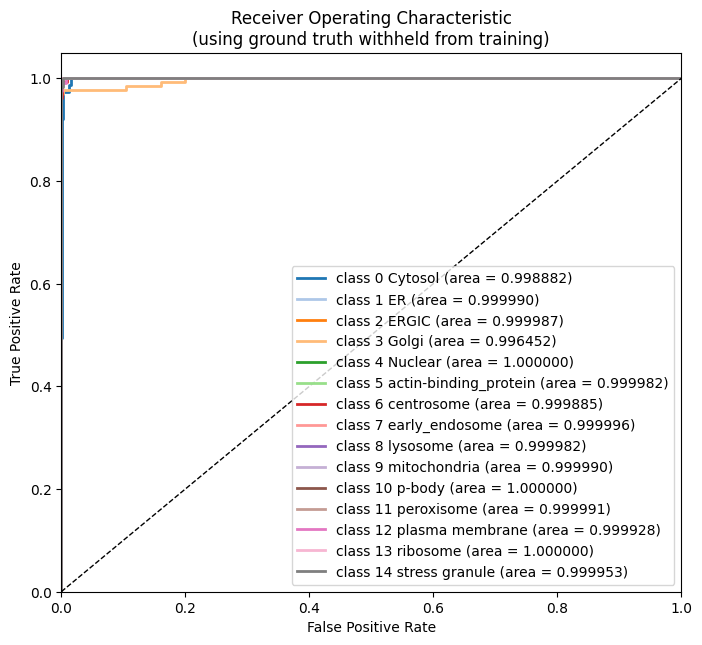

In [ ]:
plt.figure(figsize=(8,7))
# Plot the ROC curve for each class
colors = plt.cm.tab20(range(20))[0:num_classes]

#colors = ["#E6194B","#3CB44B","#FFE119","#4363D8","#F58231","#911EB4","#46F0F0","#F032E6","#BCF60C","#FABEBE","#E6BEFF",]
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='class {0} {1} (area = {2:0.6f})'
             ''.format(i, int_to_str_mapping[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic\n(using ground truth withheld from training)')
plt.legend(loc="lower right")
plt.show()

## Evaluate the classifier on non-ground truth

- use consensus_graph data where we substract PGs with ground truth
- we only use compartment classes that are in the ground truth (for which the classifier is trained to predict)

In [ ]:
# make predictions
X = scaled

model = models[0]

pred = model.predict_proba(X)
pred.shape
#pred[0,:]

(8541, 15)

#### label processing

In [ ]:
# convert the predicton labels (integers) to class names

# add class probabilities to the table
for k, v in int_to_str_mapping.items():
    umap_table[f"prob_{v}"] = pred[:,k]

# add clase predictions to the table
class_pred = pred.argmax(axis=1)
organelle_pred = [int_to_str_mapping[x] for x in class_pred]
umap_table["organelle_pred"] = organelle_pred

In [ ]:
# check the unique labels in ground truth/prediction
umap_table["organelle_pred"].unique()

array(['Nuclear', 'stress granule', 'Golgi', 'Cytosol', 'early_endosome',
       'centrosome', 'p-body', 'plasma membrane', 'ER',
       'actin-binding_protein', 'ERGIC', 'mitochondria', 'ribosome',
       'lysosome', 'peroxisome'], dtype=object)

In [ ]:
umap_table["consensus_graph_annnotation"].unique()

array(['nucleus', 'Golgi', 'cytosol', 'trans-Golgi', 'early_endosome',
       'stress_granule', 'unclassified', 'centrosome', 'ER',
       'recycling_endosome', 'plasma_membrane', 'mitochondrion',
       'lysosome', 'actin_cytoskeleton', 'translation', 'nucleolus',
       '14-3-3_scaffold', 'peroxisome', 'p-body', 'ERGIC', 'proteasome'],
      dtype=object)

In [ ]:
# create a label mapping that connects the same labels between two sets of annotations: ground truth/predcition and consensus graph annotation
lab_mapping = {"Nuclear": "nucleus",
           "Cytosol": "cytosol",
           "ribosome": "translation",
           'stress granule': "stress_granule",
           "plasma membrane": "plasma_membrane",
           "mitochondria": "mitochondrion",
           "actin-binding_protein": "actin_cytoskeleton"} # pred to expert mapping

# generate integer <-> label convertion with the new label mapping
int_to_str_mapping2 = {k:lab_mapping[v] if v in lab_mapping.keys() else v for k, v in int_to_str_mapping.items()}
str_to_int_mapping2 = {v:k for k, v in int_to_str_mapping2.items()}

converted pred labels to consensus_graph labels (for ROC curve calculation)

In [ ]:
# converted pred labels to consensus_graph labels
umap_table["organelle_pred"].replace(lab_mapping, inplace=True)
umap_table["organelle_pred"].unique()

# check if each pred label is in consensus_graph label
for i in umap_table["organelle_pred"].unique():
    if i not in umap_table["consensus_graph_annnotation"].unique():
        print(i)

#### prepare data for ROC curve calculation

Remove GT data (since we don't want to use GT data to calculate ROC curve)

In [ ]:
print(f"Number of all PGs: {umap_table.shape[0]}")
# Remove GT data
no_GT_mask = umap_table["organelle_ground_truth_v6.0"].isna()
umap_table_no_GT = umap_table[no_GT_mask].copy()
print(f"Number after removing PGs with a GT label: {umap_table_no_GT.shape[0]}")

Number of all PGs: 8541
Number after removing PGs with a GT label: 6453


Remove PGs whose classes is not in GT (therefore the classifier can't make meaningful prediction on them)

In [ ]:
# Remove compartment classes in consensus_graph but not in GT (which the model can't make meaningful predictions for)
mask = umap_table_no_GT["consensus_graph_annnotation"].isin(umap_table_no_GT["organelle_pred"].unique())
umap_table_no_GT_class_match = umap_table_no_GT[mask].copy()
print(f"Number after removing PGs with compartment that can't be mapped to on in the ground truth: {umap_table_no_GT_class_match.shape[0]}")

Number after removing PGs with compartment that can't be mapped to on in the ground truth: 5183


#### compute ROC curve

In [ ]:
# compute ROC

#subset the predictions to what's left in the umap table
y_score = pred[umap_table_no_GT_class_match.index] 

y_consensus_graph =  umap_table_no_GT_class_match["consensus_graph_annnotation"].astype("category")
y_consensus_graph = np.array([str_to_int_mapping2[s] for s in y_consensus_graph]) # Convert the list of strings to a list of integers


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_consensus_graph == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

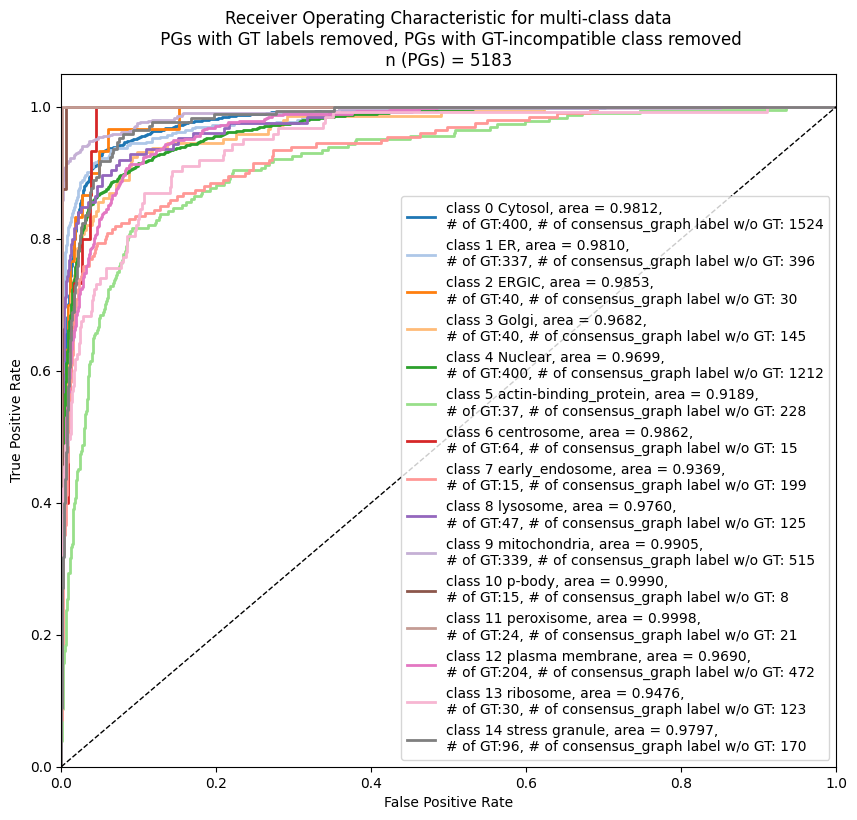

In [ ]:
plt.figure(figsize=(10,9))
# Plot the ROC curve for each class
colors = plt.cm.tab20(range(20))[0:num_classes]

#colors = ["#E6194B","#3CB44B","#FFE119","#4363D8","#F58231","#911EB4","#46F0F0","#F032E6","#BCF60C","#FABEBE","#E6BEFF",]
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='class {0} {1}, area = {2:0.4f}, \n# of GT:{3}, # of consensus_graph label w/o GT: {4}'
             ''.format(i, int_to_str_mapping[i], roc_auc[i],
                       (umap_table["organelle_ground_truth_v6.0"] == int_to_str_mapping[i]).sum(),
                       (umap_table_no_GT_class_match["consensus_graph_annnotation"] == int_to_str_mapping2[i]).sum())
            )


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for multi-class data\n PGs with GT labels removed, PGs with GT-incompatible class removed\n n (PGs) = {umap_table_no_GT_class_match.shape[0]} ')
plt.legend(loc="lower right")
plt.savefig(output_dir / f"{timestamp}__{now_timestamp}_AUC_ROC.pdf", format="pdf", bbox_inches='tight')
plt.show()

## Plot prediction probabilities on UMAP

In [ ]:
plot_dir = output_dir / "plots"
plot_dir.mkdir(exist_ok=True)

# flip the umap coordinates (needed in some cases)
max_x = max(umap_table["umap_1"])
max_y = max(umap_table["umap_2"])
umap_1_flip = max_x - umap_table["umap_1"]
umap_2_flip = max_y - umap_table["umap_2"]
umap_table["umap_1_flip"] = umap_1_flip
umap_table["umap_2_flip"] = umap_2_flip

plot class prediction

In [ ]:
# generate 2D UMAP plot (hightlighted by Leiden clusters)
label_to_color = "organelle_pred" # **choose which annotation column to highlight here**

fig = pu.interaction_umap(umap_table,
    node_name='consensus_graph_annnotation', cluster=label_to_color,
    unlabelled_color='#D0D3D4', unlabelled_opacity=0.1,
    x='umap_1', y='umap_2',
    categorical=True)
fig.update_layout(width=1200, height=800)
fig.update_layout(title_text=f"Classifier: {label_to_color}")

#save the figure as an html file
pio.write_html(fig, file=plot_dir / f"{timestamp}__{now_timestamp}_UMAP_{label_to_color}.html", auto_open=False)

plot probability

In [ ]:
for col in umap_table.columns:
    if col.startswith("prob"):
        # generate 2D UMAP plot (hightlighted by Leiden clusters)
        label_to_color = col # **choose which annotation column to highlight here**

        fig = pu.interaction_umap(umap_table,
            node_name='consensus_graph_annnotation', cluster=label_to_color,
            unlabelled_color='#D0D3D4', unlabelled_opacity=0.1,
            x='umap_1', y='umap_2',
            categorical=False)
        fig.update_layout(width=1200, height=800)
        fig.update_layout(title_text=f"Probability: {label_to_color.replace('prob_','')}")

        #save the figure as an html file
        pio.write_html(fig, file=plot_dir / f"{timestamp}__{now_timestamp}_UMAP_{label_to_color}.html", auto_open=False)

### Using same color mapping to plot the class-prediction and consensus_graph labels

In [ ]:
# fill na
umap_table["consensus_graph_annnotation"].fillna("unlabeled", inplace=True)

In [ ]:
# get the list of unique labels
unique_exp_clusters = umap_table["consensus_graph_annnotation"].unique()
unique_pred_labels = umap_table["organelle_pred"].unique()

all_labels = pd.concat([umap_table["consensus_graph_annnotation"],umap_table["organelle_pred"]]).unique()
all_labels = [lab_mapping[i] if i in lab_mapping.keys() else i for i in all_labels]
all_labels = list(set(all_labels))

print(f"total number of labels is {len(all_labels)}")

total number of labels is 21


In [ ]:
# define the color palette for the of unique labels
total_color = len(sorted(all_labels))
if total_color <= 20:
    palette = sns.color_palette("tab20", n_colors=total_color)
else:
    palette = sns.color_palette("tab20", n_colors=20) + sns.color_palette("tab20b", n_colors=20)[-(total_color-20):]

# generate color mapping for the consensus_graph labels
color_mapping_Oct25 = dict(zip(unique_exp_clusters, palette))
# use the same color mapping for the predicted labels
color_mapping_pred = {p : color_mapping_Oct25[lab_mapping[p]] if p in lab_mapping.keys() else color_mapping_Oct25[p] for p in unique_pred_labels}

# convert colors to hex
def rgb_to_css_color(rgb_tuple):
    """Convert RGB tuple in [0, 1] range to CSS color (hexadecimal format)."""
    return "#{:02x}{:02x}{:02x}".format(
        int(rgb_tuple[0] * 255),
        int(rgb_tuple[1] * 255),
        int(rgb_tuple[2] * 255)
    )
color_mapping_Oct25 = {k: rgb_to_css_color(v) for k, v in color_mapping_Oct25.items()}
color_mapping_pred = {k: rgb_to_css_color(v) for k,v in color_mapping_pred.items()}

In [ ]:
# plot side-by-side
fig1 = px.scatter(
            umap_table,
            x="umap_1",
            y="umap_2",
            hover_name='Gene_name_canonical',
            color="consensus_graph_annnotation",
            #color_continuous_scale=px.colors.cyclical.mygbm[: -1], # small palette (Kibeom)
            #color_discrete_sequence=px.colors.qualitative.Dark24, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            color_discrete_map = color_mapping_Oct25, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            hover_data=None,
            template='simple_white')
fig1.update_traces(marker=dict(size=6))
fig1.update(layout_coloraxis_showscale=False)
fig1.update_layout(width=1200, height=800)
fig1.update_layout(title_text=f"Consensus graph annnotation", title_x=0.5, title_y=0.95, title_font_size=20)
fig1.update_legends(title_text='consensus graph annnotation', title_font_size=16, font_size=16 )

pio.write_html(fig1, file=plot_dir / f"{timestamp}_UMAP_consensus_graph_annnotation.html", auto_open=False)

fig1


In [ ]:

fig2 = px.scatter(
            umap_table,
            x="umap_1",
            y="umap_2",
            hover_name='Gene_name_canonical',
            color="organelle_pred",
            #color_continuous_scale=px.colors.cyclical.mygbm[: -1], # small palette (Kibeom)
            #color_discrete_sequence=px.colors.qualitative.Dark24, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            color_discrete_map = color_mapping_pred, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            hover_data=None,
            template='simple_white')
fig2.update_traces(marker=dict(size=6))
fig2.update(layout_coloraxis_showscale=False)
fig2.update_layout(width=1200, height=800)
fig2.update_layout(title_text=f"Classifier prediction", title_x=0.5, title_y=0.95, title_font_size=20)
fig2.update_legends(title_text='Predicted compartment', title_font_size=16, font_size=16)

pio.write_html(fig1, file=plot_dir / f"{timestamp}_UMAP_predicted_compartment.html", auto_open=False)
fig2

## calculate prediction uncertainty

In [ ]:
def calculate_entropy(probabilities):
    """
    Calculate the entropy of a probability distribution.
    
    :param probabilities: array-like, probabilities for each class
    :return: entropy, a measure of uncertainty of the prediction
    """
    # Replace 0s with 1s to handle log(0) case, as log(1) = 0
    probabilities = np.clip(probabilities, 1e-10, 1)
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

def calculate_predictive_margin(probabilities):
    """
    Calculate the predictive margin of a probability distribution.
    
    :param probabilities: array-like, probabilities for each class
    :return: margin, difference between the highest and second highest probability
    """
    sorted_probs = np.sort(probabilities)  # Sort the probabilities
    margin = sorted_probs[-1] - sorted_probs[-2]  # Subtract the second highest from the highest
    return margin

In [ ]:
entropies = []
margins = []
for idx, row in umap_table.iterrows():
    prob_cols = [i for i in row.index if i.startswith("prob")]
    prob_list = np.array(list(row[prob_cols]))
    entropy = calculate_entropy(prob_list)
    margin = calculate_predictive_margin(prob_list)
    entropies.append(entropy)
    margins.append(margin)

# add entropy and margins to the dataframe
umap_table["predictive_entropy"] = entropies
umap_table["predictive_margin"] = margins

## write umap table (with predictions) to file

In [ ]:
umap_table.to_csv(output_dir / f"{timestamp}__{now_timestamp}_UMAP_table_w_predictions.csv", index=False)

## save the model to file

In [ ]:
model_file_name = f"{timestamp}__{now_timestamp}_xgb_model_"
model.save_model(output_dir / f"{model_file_name}.json")

## save variables to file (for reproducibility)

In [ ]:
# Save the environment

with open(output_dir / f'{timestamp}__{now_timestamp}_vars.dill', 'wb') as f:
    dill.dump([gt_X_bal, gt_y_bal, X_y_splits, unseen, models], f)